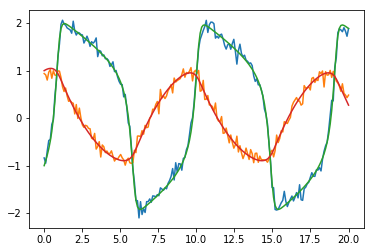

In [11]:
import matplotlib.pyplot as plt
import pints
import pints.toy as toy
import numpy as np

# Load a forward model

#model = pints.toy.LotkaVolterraModel()
model = pints.toy.FitzhughNagumoModel()

    
# Create some toy data
real_parameters = np.array(model.suggested_parameters(), dtype='float64')
times = model.suggested_times()
org_values = model.simulate(real_parameters, times)

# Add noise
np.random.seed(1)
noise = 0.1
values = org_values + np.random.normal(0, noise, org_values.shape)

plt.figure()
plt.plot(times, values)
plt.plot(times, org_values)
plt.show()

In [2]:
# Create an object with links to the model and time series
problem = pints.MultiOutputProblem(model, times, values)

# Create a log-likelihood function
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

# Create a wrapper around the logistic model, using autodiff to calculate the 
class AutoGradLogLikelihood(pints.ProblemLogLikelihood):
    def __init__(self, likelihood):
        self.likelihood = likelihood
        f = lambda x: self.likelihood(x)
        self.likelihood_grad = grad(f)
    def __call__(self, x):
        return self.likelihood(x)
    def evaluateS1(self, x):
        values = self.likelihood(x)
        gradient = self.likelihood_grad(x)
        return values, gradient
    def n_parameters(self):
        return self.likelihood.n_parameters()

autodiff_likelihood = AutoGradLogLikelihood(log_likelihood)

In [9]:
%timeit autodiff_likelihood.evaluateS1(real_parameters)

5.31 s ± 70 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit log_likelihood.evaluateS1(real_parameters)

45.9 ms ± 674 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
